In [1]:
# Regular Funcs
import os
import cv2
import glob
import shutil

import pandas as pd
import pathlib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image as ImagePIL
import plotly.express as px
import plotly.graph_objects as go

from numpy.random import randint

In [2]:
# Statistics
from scipy import stats

In [3]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential

from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2DTranspose
from keras.layers import Reshape
from keras import backend

from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint


2023-07-05 17:50:46.129273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Custom Funcs
from Unpack_Scaffold_Data import readAndOutputDataset, curveVisualization

# Data Read Utility

In [5]:
curve_path = "/Users/zacharyg/Documents/GitHub/fundemental-neural-nets/GANS/Scaffold_GAN/scaffold_dataset_WU_LAB/Prints"
modulus_path = "/Users/zacharyg/Documents/GitHub/fundemental-neural-nets/GANS/Scaffold_GAN/scaffold_dataset_WU_LAB/Prints/modulus_data_types.csv"


In [6]:
X, y, y_df, file_order = readAndOutputDataset(curve_path, modulus_path, reverse=True);

DOC COUNT: 675
Operation Finished.

     Index     Modulus  Spacing  Infill  Height  Speed  Temperature   Mass  \
0        1  358.528888      0.8       1     0.1     30          190  0.394   
1        2  301.639039      0.9       1     0.1     30          190  0.334   
2        3  292.501492      1.0       1     0.1     30          190  0.308   
3        4  258.539802      1.1       1     0.1     30          190  0.286   
4        5  238.213024      1.2       1     0.1     30          190  0.259   
..     ...         ...      ...     ...     ...    ...          ...    ...   
670    671  151.559731      0.8       3     0.2     50          230  0.428   
671    672   85.074096      0.9       3     0.2     50          230  0.341   
672    673   52.285252      1.0       3     0.2     50          230  0.290   
673    674   70.811230      1.1       3     0.2     50          230  0.292   
674    675   36.627466      1.2       3     0.2     50          230  0.244   

     Porosity    Type  
0  

In [7]:
# Sanity Check
print("X SHAPE:", X.shape);
print("y SHAPE:", y.shape);
print();


# Visualization
# curveVisualization(X, y, file_order);

X SHAPE: (675, 2, 1803)
y SHAPE: (675, 10)



# Utility

In [8]:
def transposeStressData(X_Data):
    X = [];
    
    for data in X_Data:
        X.append(data.T);
        
    return np.array(X);

def normalizeStressStrain(x):
    for curve_index in range(len(x)):
        curve = x[curve_index];
        
        max_stress_val = np.max(curve[0]);
        max_strain_val = np.max(curve[1]);
        
        curve[0] = curve[0] / max_stress_val;
        curve[1] = curve[1] / max_strain_val;
        
    return x;

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    
    Parameters
    -----------------
    x: Array of Homogenous (RGB) values of input data 
    
    Returns
    -----------------
    new_imgs: (numpy integer array) Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

def stringtoCategorical(y):    
    data = [];
    
    for type_index in range(len(y)):
        wrd = y[type_index];
        encoding = 0.0;
        
        if (wrd == "Cubic"):
            encoding = 1.0;
        elif (wrd == "Gyroid"):
            encoding = 2.0;
            
        data.append([encoding]);
        
    return np.array(data);

# Process Parameter Stripping

In [9]:
def parameterStrip(y):
    y_t = y.T;
    
    Index = y_t[0];
    Modulus = y_t[1];
    Spacing = y_t[2];
    Infill = y_t[3];
    Height = y_t[4];
    Speed = y_t[5];
    Temp = y_t[6];
    Mass = y_t[7];
    Porosity = y_t[8];
    Type = y_t[9];
    return Index, Modulus, Spacing, Infill, Height, Speed, Temp, Mass, Porosity, Type

Index, Modulus, Spacing, Infill, Height, Speed, Temp, Mass, Porosity, Type = parameterStrip(y);

# Stress String Characteristics

X_Data -> 675 Stress Strain Curves

Features that is calculated from the Curve:
* Energy Absorption (No calculation yet...)
* Compression Modulus
* Porosity

Printing Parameters:
* Infill Pattern (1-3)
* Line Distance
* Weight
* Print Speed
* Layer Height
* Print Temperature

Perhaps we can try to represent these things with an image. We have a table:

Let $x_n \in \{(R, G, B)\}$, where $R,G,B \in \mathbb{R}$

|             | $P_1$   | $P_2$   | $P_3$   | $P_4$   | $\dots$ | 
| ----------- | ------- | ------- | ------- | ------- | ------- |
| $c_1$       |  $x_1$  |  $x_2$  |  $x_3$  |  $x_4$  |  $x_5$  |
| $c_2$       |  $x_6$  |  $x_7$  |  $x_8$  |  $x_9$  |$\vdots$ |
| $\vdots$     |  $x_{11}$|  $x_{12}$  |  $x_{13}$  |  $\dots$  |$x_{k}$ |


So by designing a $m \times n$ matrix:

$$
\begin{bmatrix}
x_1 & x_2 & \dots & x_m\\
y_1 & y_2 & \dots & y_m
\end{bmatrix}
$$

In [10]:
def plotSimpleScatter(X, y, title="Curve", xlabel="Steps", ylabel="Value", size=20):
    x_axis = X
    y_axis = y

    plt.scatter(x_axis, y_axis, s=size)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    

def plotPlotlyScatter(X, y):
    fig = px.scatter(x=X, y=y)
    fig.show()

stress_strain_domain = list(range(675 + 1));
stress_strain_domain.pop(0);

In [11]:
print("Modulus Max:", np.max(Modulus));
print("Porosity Max:", np.max(Porosity));

Modulus Max: 827.9307229
Porosity Max: 0.8512


### Spearman Correlation

Spearman’s rank correlation coefficient, denoted by $r_s$, is a numerical value such that $-1 \leq 1 \leq 1$. It gives a measure of the likelihood of one variable increasing as the other increases (a direct association) or of one variable decreasing as the other increases (an inverse association). Direct associations are indicated by positive values, and inverse associations are indicated by negative values. No association is indicated by a value of $0$. The stronger the association, the closer $r_s$ is to $−1$ or $1$, and the weaker the association, the closer it is to $0$. Rank correlation coefficient values of $1$ or $−1$ mean that either the ranks agree entirely $(r_s = 1)$ or they are direct opposites $(r_s = -1)$.

The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

In [12]:
Parameter_Sum = [];

for index in range(len(Spacing)):
    Summation = Spacing[index] + Infill[index] + Height[index] + Speed[index] + Temp[index];
    Parameter_Sum.append(Summation);

In [13]:
Parameter_Sum

[284.4,
 284.3,
 284.2,
 284.1,
 284.0,
 283.4,
 283.3,
 283.2,
 283.1,
 283.0,
 282.4,
 282.3,
 282.2,
 282.1,
 282.0,
 264.4,
 264.3,
 264.2,
 264.1,
 264.0,
 263.4,
 263.3,
 263.2,
 263.1,
 263.0,
 262.4,
 262.3,
 262.2,
 262.1,
 262.0,
 244.4,
 244.3,
 244.2,
 244.1,
 244.0,
 243.4,
 243.3,
 243.2,
 243.1,
 243.0,
 242.4,
 242.3,
 242.2,
 242.1,
 242.0,
 279.4,
 279.3,
 279.2,
 279.1,
 279.0,
 278.4,
 278.3,
 278.2,
 278.1,
 278.0,
 277.4,
 277.3,
 277.2,
 277.1,
 277.0,
 259.4,
 259.3,
 259.2,
 259.1,
 259.0,
 258.4,
 258.3,
 258.2,
 258.1,
 258.0,
 257.4,
 257.3,
 257.2,
 257.1,
 257.0,
 239.4,
 239.3,
 239.2,
 239.1,
 239.0,
 238.4,
 238.3,
 238.2,
 238.1,
 238.0,
 237.4,
 237.3,
 237.2,
 237.1,
 237.0,
 274.4,
 274.3,
 274.2,
 274.1,
 274.0,
 273.4,
 273.3,
 273.2,
 273.1,
 273.0,
 272.4,
 272.3,
 272.2,
 272.1,
 272.0,
 254.4,
 254.3,
 254.2,
 254.1,
 254.0,
 253.4,
 253.3,
 253.2,
 253.1,
 253.0,
 252.4,
 252.3,
 252.2,
 252.1,
 252.0,
 234.4,
 234.3,
 234.2,
 234.1,
 234.0,


In [16]:
# Modulus vs. Combinations
# Parameter_Sum_norm = normalize(Parameter_Sum);
# Modulus_norm = normalize(Modulus);

Modulus_Sum = stats.spearmanr(Modulus, Parameter_Sum)
print("Statistics:", Modulus_Sum.statistic);
print("pvalue:", Modulus_Sum.pvalue);

plotPlotlyScatter(
    stress_strain_domain,
    Modulus
);

plotPlotlyScatter(
    stress_strain_domain,
    Parameter_Sum
);

# plotSimpleScatter(
#     stress_strain_domain_modified, 
#     Modulus, 
#     title="Modulus Points", 
#     xlabel="Stress-Strain Curve",
#     ylabel="Modulus",
#     size=5
# );

# plotSimpleScatter(
#     stress_strain_domain_modified, 
#     Parameter_Sum, 
#     title="Parameter Sum Points", 
#     xlabel="Stress-Strain Curve",
#     ylabel="Parameter Sum",
#     size=5
# );

Statistics: 0.05802618945925143
pvalue: 0.13205701228510444


Statistics: -0.8583172019474729
pvalue: 3.395743282289437e-197


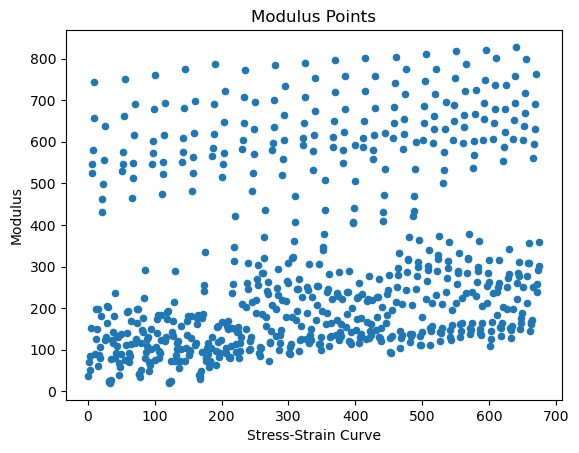

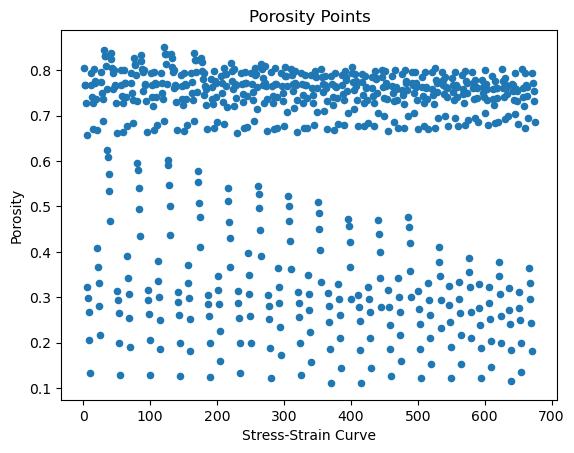

In [17]:
# Modulus vs. Porosity: Inverse Correlation (One is going up strongly while the other is going down)
Modulus_Porosity = stats.spearmanr(Modulus, Porosity)
print("Statistics:", Modulus_Porosity.statistic);
print("pvalue:", Modulus_Porosity.pvalue);

plotSimpleScatter(
    stress_strain_domain, 
    Modulus, 
    title="Modulus Points", 
    xlabel="Stress-Strain Curve",
    ylabel="Modulus"
);

plotSimpleScatter(
    stress_strain_domain, 
    Porosity, 
    title="Porosity Points", 
    xlabel="Stress-Strain Curve",
    ylabel="Porosity"
);

Statistics: 0.8583172019474729
pvalue: 3.395743282289437e-197


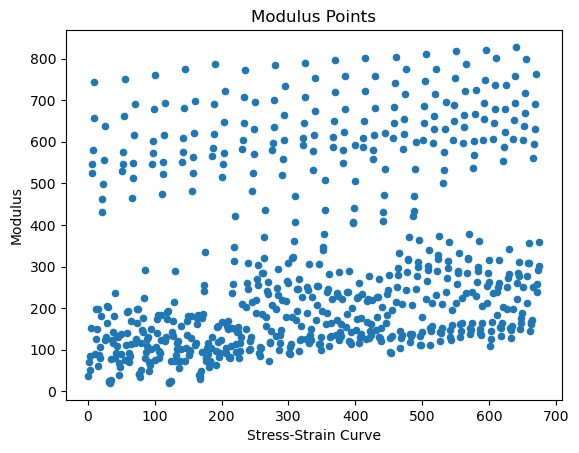

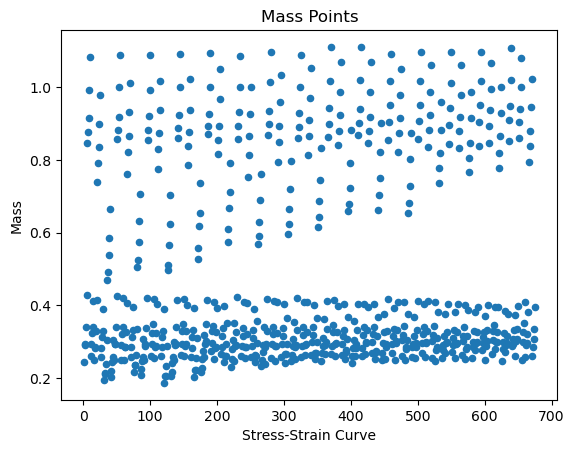

In [18]:
# Modulus vs. Mass: Strong Same Correlation (Both are heading at the same time)
Modulus_Mass = stats.spearmanr(Modulus, Mass)
print("Statistics:", Modulus_Mass.statistic);
print("pvalue:", Modulus_Mass.pvalue);

plotSimpleScatter(
    stress_strain_domain, 
    Modulus, 
    title="Modulus Points", 
    xlabel="Stress-Strain Curve",
    ylabel="Modulus"
);

plotSimpleScatter(
    stress_strain_domain, 
    Mass, 
    title="Mass Points", 
    xlabel="Stress-Strain Curve",
    ylabel="Mass"
);

Statistics: -0.3133109198464713
pvalue: 7.700923437239998e-17


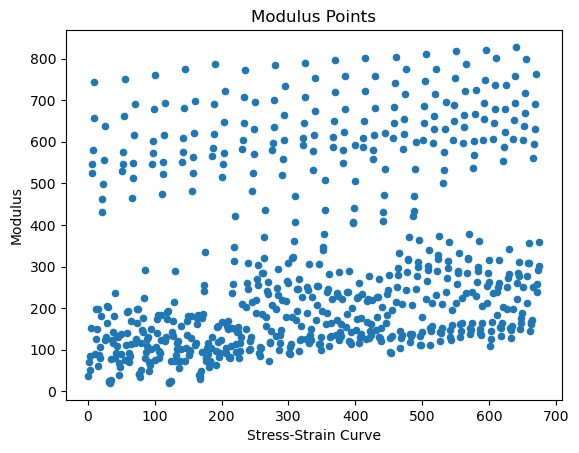

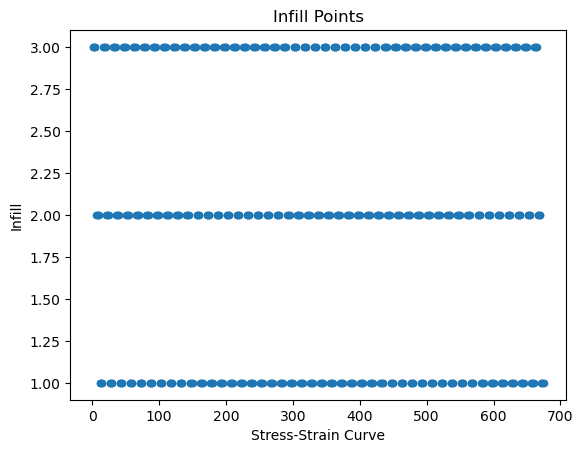

In [19]:
# Modulus vs. Infill Type: Almost No Correlation
Modulus_Infill = stats.spearmanr(Modulus, Infill)
print("Statistics:", Modulus_Infill.statistic);
print("pvalue:", Modulus_Infill.pvalue);

plotSimpleScatter(
    stress_strain_domain, 
    Modulus, 
    title="Modulus Points", 
    xlabel="Stress-Strain Curve",
    ylabel="Modulus"
);

plotSimpleScatter(
    stress_strain_domain, 
    Infill, 
    title="Infill Points", 
    xlabel="Stress-Strain Curve",
    ylabel="Infill"
);

Statistics: -0.27306363686658225
pvalue: 5.241529913476244e-13


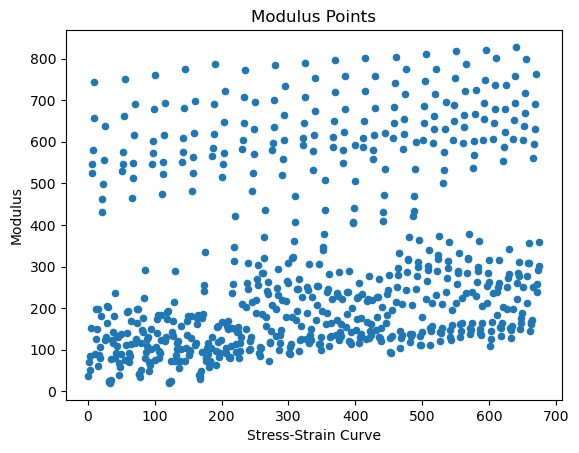

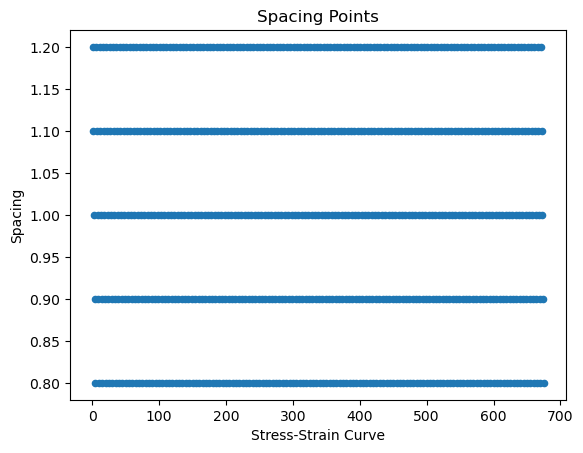

In [20]:
# Modulus vs. Spacing Type:
Modulus_Spacing = stats.spearmanr(Modulus, Spacing)
print("Statistics:", Modulus_Spacing.statistic);
print("pvalue:", Modulus_Spacing.pvalue);

plotSimpleScatter(
    stress_strain_domain, 
    Modulus, 
    title="Modulus Points", 
    xlabel="Stress-Strain Curve",
    ylabel="Modulus"
);

plotSimpleScatter(
    stress_strain_domain, 
    Spacing, 
    title="Spacing Points", 
    xlabel="Stress-Strain Curve",
    ylabel="Spacing"
);

# Simple 1D GAN

### Looking at Overall Feature Data Distributions

Let $D$ be a set of sets such that $|D| = 675$. Let $d_1, d_2, ..., d_n \in D$ be the set within sets. Printing scalar values that are set during the printing process. Suppose that $C$ and $P$ denote specimen attributes and printing parameters respectively.

We denote that $d_n = \{C_1, P_1, P_2, P_3, P_4, P_5, C_2, C_3\}$ be denoted as **Compression Modulus, Spacing, Infill Type, Height, Speed, Temperature, Weight, and Porosity** respectively, where  $C_1, P_1, P_2, P_3, P_4, P_5, C_2, C_3 \geq 0$.

An additional parameter to note, for **Infill Type**, the values are fixed discretely such that:

 $$Infill \ Type(P_2) = \begin{cases}
  1  & P_2 \text{ is Line} \\
  2  & P_2 \text{ is Cubic} \\
  3  & P_2 \text{ is Gyroid}
\end{cases}$$

In [21]:
print(y)
print()
cut_params = y[:, 1:9];

# Plot the entire distribution across 675
feature_domain_675 = list(range(675 + 1));
feature_domain_675.pop(0) 
feature_domain_675 = np.repeat(feature_domain_675, 8, axis=0)

_cut_params = cut_params;
cut_params = cut_params.flatten();

print(_cut_params);
print();
print(cut_params);

fig = px.scatter(
    x=feature_domain_675, 
    y=cut_params,
    title="Each point of dataset over 675 curves"
)
fig.show()

[[675 36.62746579 1.2 ... 0.244 0.8048 'Gyroid']
 [674 70.81123039 1.1 ... 0.292 0.7664 'Gyroid']
 [673 52.28525229 1.0 ... 0.29 0.768 'Gyroid']
 ...
 [3 292.5014925 1.0 ... 0.308 0.7536 'Line']
 [2 301.639039 0.9 ... 0.334 0.7328 'Line']
 [1 358.5288882 0.8 ... 0.394 0.6848 'Line']]

[[36.62746579 1.2 3 ... 230 0.244 0.8048]
 [70.81123039 1.1 3 ... 230 0.292 0.7664]
 [52.28525229 1.0 3 ... 230 0.29 0.768]
 ...
 [292.5014925 1.0 1 ... 190 0.308 0.7536]
 [301.639039 0.9 1 ... 190 0.334 0.7328]
 [358.5288882 0.8 1 ... 190 0.394 0.6848]]

[36.62746579 1.2 3 ... 190 0.394 0.6848]


In [22]:
# Normalize the data
cut_params_N = [];
max_value = np.max(_cut_params);
print("The Max value is:", max_value);

for curve in _cut_params:
#     print(curve)
    cut_params_N.append(curve / max_value);
#     print(normalize(curve))
    
cut_params_N = np.array(cut_params_N);
# print(cut_params_N)
# print()
# print(cut_params_N[0])
# print()
# print(cut_params_N[1])
# print()
# print(cut_params_N[2])

cut_params_N_Flatten = cut_params_N.flatten();

# Just as a sanity check...
# plotPlotlyScatter(
#     feature_domain_675,
#     cut_params_N_Flatten
# );
fig = px.scatter(
    x=feature_domain_675, 
    y=cut_params_N_Flatten,
    title="Each point of dataset over 675 curves"
)
fig.show()



The Max value is: 827.9307229


### Looking at each parameter distribution

In [23]:
feature_domain_8 = list(range(8 + 1));
feature_domain_8.pop(0);

feature_domain_8_rep = list(np.arange(1,9))*675


# print(feature_domain_8);
# print(feature_domain_8_rep);

# Just to view one:
plotPlotlyScatter(
    feature_domain_8,
    cut_params_N[0]
);

# View ALL (FULL DISTRIBUTION)
plotPlotlyScatter(
    feature_domain_8_rep,
    cut_params
);

 Let $\{C_1, P_1, P_2, P_3, P_4, P_5, C_2, C_3\}$ represent the $1-8$ respectively.

In [24]:
# Single Lines Chart (DISTRIBUTION)
fig_k = px.line(
    x=feature_domain_8, 
    y=cut_params_N[200],
    title="Single Parameter Curve",
    labels={"x": "Parameters", "y":"Normalized values (Divided by Max)"}
)

fig_k.show()


# Multiple Lines Chart (DISTRIBUTION)
fig = go.Figure()

for line in range(len(cut_params_N)):
    data = cut_params_N[line];
    fig.add_trace(go.Scatter(x=feature_domain_8, y=data))

fig.show()

### Discriminator Data Sampling Generator

In [ ]:
def sample_real_samples(dataset, n_samples):
    """
    Parameters
    --------------
    real_dataset: dataset with the real data
    n_samples: amount of real images to sample from
    
    Returns
    --------------
    X: samples of n images in a list
    Y: labels of (1's) for true images (Binary Classification)
    """
    if (isinstance(dataset, list)):
        dataset = np.asarray(dataset);
        
    random_num = randint(0, dataset.shape[0], n_samples);
    X = dataset[random_num];
    y = np.ones((n_samples, 1));
    
    return X, y

### Discriminator

In [ ]:
def simpleDiscriminator(in_shape=8):
    """
    """
    model = tf.keras.Sequential();
    
    model.add(Dense(100, input_dim=in_shape, activation='relu')) 
    model.add(Dense(8, input_dim=in_shape, activation='relu')) 
    model.add(Dense(1, activation='sigmoid')) # Since the decision is binary (Real | Fake), we use sigmoid
    
    opt = Adam(learning_rate =0.001)
    model.compile(
        loss='binary_crossentropy', 
        optimizer = opt, 
        metrics=['accuracy']
    )
    
    return model

### Generator

In [ ]:
def simpleGenerator(in_shape=8):
    model = tf.keras.Sequential();
    
    model.add(Dense(8, input_dim=in_shape, activation="relu"))
    model.add(Dense(8, input_dim=in_shape, activation="relu"))
    model.add(Dense(8)) 
    
    return model;

### Summary of Models

In [ ]:
discriminator = simpleDiscriminator();
generator = simpleGenerator();

In [ ]:
discriminator.summary();
generator.summary();

### Latent Space

In [ ]:
def latentDimensionalGenerator(latent_dimensions, n_samples, randomGaussian = False):
    data = [];
    
    for sample in range(n_samples):
        x_input_0 = np.random.randn(latent_dimensions); # Points sampled from a normalized distribution.
        data.append(x_input_0);
        
    return np.array(data)

In [ ]:
# Generator production
def generate_samples(g_model, latent_dim, n_samples):
    x_input = latentDimensionalGenerator(latent_dim, n_samples)  # generate points in a latent space
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))  # create 'fake' class labels (0)
    return X, y

### Visualizing the latent dimensional space in 2D

In [ ]:
# k = latentDimensionalGenerator(8, 10)
# print(k)

fake_X, fake_y = generate_samples(generator, 8, 10);
print(fake_X.shape)

In [ ]:
for curve in fake_X:
    fig = go.Figure();
    fig.add_trace(go.Scatter(x=feature_domain_8, y=curve));
    fig.show();

### GAN: Putting it together

In [ ]:
def define_gan(generator, discriminator):
    discriminator.trainable = False # We set the discriminator as not trainable so the generator updates
    model = tf.keras.Sequential() 
    
    model.add(generator)
    model.add(discriminator)
    
    opt = Adam(learning_rate = 0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt) # Generator will train on this loss
    return model

# Evaluation Metrics

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples, save_path=""):
    # Real Images based on discriminator
    X_real, y_real = sample_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    # Fake Images based on discriminator
    x_fake, y_fake = generate_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    print("============== CURVE GENERATION ON EPOCH", epoch,"==============");
    
    for curve in x_fake:
        plt.plot(feature_domain_8, curve)
    
    if (save_path != ""):
        plt.title("Training in epoch: " + str(epoch))
        plt.savefig(os.path.join(save_path, str(epoch) + '.png'));
        
    plt.show()
    
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100));

# GAN Training

In [ ]:
# train the generator and discriminator
def train_gan(g_model, d_model, gan_model, training_data, latent_dim, n_epochs, n_batch, save_path=""):
    d1Loss = [];
    d2Loss = [];
    gLoss = [];
    
    half_batch = int(n_batch / 2);
    
    for i in range(n_epochs):                
        # Real Image Discriminator Training
        X_real, y_real = sample_real_samples(training_data, half_batch)
        d_loss1, _ = d_model.train_on_batch(X_real, y_real) # Training on real

        # Fake Image Discriminator Training
        X_fake, y_fake = generate_samples(g_model, latent_dim, half_batch)
        d_loss2, _ = d_model.train_on_batch(X_fake, y_fake) # Training on fakes

        # Create a latent space and inverted labels
        X_gan = latentDimensionalGenerator(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1)) # Pretend that that they are all real.

        # Update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)

        # summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
        summarize_performance(i, g_model, d_model, training_data, latent_dim, 100, save_path)
        
        d1Loss.append(d_loss1);
        d2Loss.append(d_loss2);
        gLoss.append(g_loss);
        
    return d1Loss, d2Loss, gLoss;

In [ ]:
latent_dim = 8;
gan_model = define_gan(generator, discriminator);

In [ ]:
print(os.getcwd());
os.chdir("/Users/zacharyg/Documents/GitHub/fundemental-neural-nets/GANS/Scaffold_GAN");
image_save_path = "./images/"

if not os.path.exists(image_save_path):
    os.makedirs(image_save_path);

In [ ]:
n_epochs = 3000;
X = cut_params_N.astype('float32')

#Training
d1, d2, gloss = train_gan(
    generator, 
    discriminator, 
    gan_model, 
    X, 
    latent_dim, 
    n_epochs, # n_epochs
    20,  # batch size
    save_path = image_save_path
);

 Try #1 -> A Good convergence is like 6000 epochs...

In [ ]:
def plotCurve(X, y, title="Curve", xlabel="Steps", ylabel="Value"):
    x_axis = X
    y_axis = y

    plt.plot(x_axis, y_axis)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
epochs = list(range(n_epochs + 1));
popping = epochs.pop(0);

In [ ]:
plotCurve(epochs, d1, title="d1 loss");
plotCurve(epochs, d2, title="d2 loss");
plotCurve(epochs, gloss, title="GAN Loss");

# Save GIF

In [ ]:
# Quick n' dirty way of saving to GIF
import imageio.v2 as imageio

input_folder = "./images/"
output_folder = './Movie_Data/';

if not os.path.exists(output_folder):
    os.makedirs(output_folder);

images = []
image_name_arr_out = glob.glob(os.path.join(input_folder, "*.png")) + glob.glob(os.path.join(input_folder, "*.tif")) + glob.glob(os.path.join(input_folder, "*.jpg"));

for filename in sorted(image_name_arr_out, key = lambda x:x[0:]):
    images.append(imageio.imread(filename))
imageio.mimsave(os.path.join(output_folder, "GAN.gif"), images);

# Prediction Output

In [ ]:
fake_X, fake_y = generate_samples(generator, 8, 100);

print(fake_X)
print()

print(fake_X[99])
print()
print(fake_X[99] * max_value)
    
# Single Lines Chart (DISTRIBUTION)
fig_k = px.line(
    x=feature_domain_8, 
    y=fake_X[99] * max_value,
    title="Single Parameter Curve",
    labels={"x": "Parameters", "y":"Normalized values (Divided by Max)"}
)

fig_k.show()

In [ ]:
print(cut_params_N[199])
print();
print(cut_params_N[199] * max_value)

# Single Lines Chart (DISTRIBUTION)
fig_k = px.line(
    x=feature_domain_8, 
    y=cut_params_N[199] * max_value,
    title="Single Parameter Curve",
    labels={"x": "Parameters", "y":"Normalized values (Divided by Max)"}
)

fig_k.show()